## Import Packages

In [24]:
import random
from collections import defaultdict
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## Generate data points in 2D space

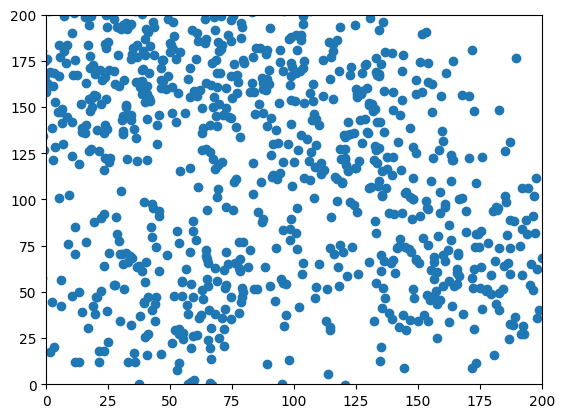

In [25]:
num_clusters = 5
num_dimensions = 2
points_per_cluster = 200
m = num_clusters * points_per_cluster

cluster_centers = np.random.rand(num_clusters, 2) * 200

x = np.empty(0)
y = np.empty(0)

for center in cluster_centers:
    x = np.concatenate([x, np.random.randn(points_per_cluster) * 30 + center[0]])
    y = np.concatenate([y, np.random.randn(points_per_cluster) * 30 + center[1]])

plt.scatter(x, y)
plt.xlim(0, 200)
plt.ylim(0, 200)
plt.show()

When calculating the L2 difference between centroids and data points, for faster calculation, we use matrix subtraction. For this, we reshape the data points from (m, num_dimension) to (m, num_dimension, num_centroids) by repeating along the last dimension.

In [26]:
data = np.array([x, y])
data = data.reshape(1000, 2)
data = np.expand_dims(data, axis=2)
data = np.repeat(data, 5, axis=-1)
data.shape # (m, num_dimensions, num_cluster)

(1000, 2, 5)

## K-means Algorithm

K-means algorithm:

```
Randomally initalize K cluster centroids

Repeat {
  # assign points to closet cluster centroids
  for i to range(len(points)):
    get index of cluster centroids close to each point

  # move cluster centroids
  for k=1 to K
    move position of k as mean of assigned points
}

```

- How you randomally initalize first K centroids can effect cost function alot. So we repeat above procedure with different initalization multiple times then select centroids that give lowest J.

- When initalizing K cluster centroids, you can just pick K points randomally.

1. Randomly ititalize K cluster centroids


In [27]:
k_centroids = []
num_clusters = 5

for i in range(num_clusters):
  random_index = random.randint(0, 999)
  curr = data[i, :, 0]
  k_centroids.append(curr)

k_centroids = np.array(k_centroids)
k_centroids.shape # (num_centroids, num_dimensions)

(5, 2)

2. Assign points to closet centroids

In [28]:
def reshape_centroids(k_centroids):
  ''' resahpe k_centroids from (num_cluster, num_dimensions) to (m, num_dimensions, num_cluster) by repeating
  along the first dimension, so that we can compute difference between each centroid and each data points faster using matrix operations.
  Args:
    k_centroids: (num_cluster, num_dimensions)
  Outputz;
   k_centroids_reshaped: (m, num_dimensions, num_cluster)
  '''
  k_centroids_reshaped = k_centroids.reshape(1, num_dimensions, num_clusters)
  k_centroids_reshaped = np.repeat(k_centroids_reshaped, 1000, axis=0)
  return k_centroids_reshaped

In [29]:
def convert_dict2numpy(new_centroids):
  ''' convert dictionary into a numpy array
  Args:
    new_centroids: dictionary where each key represents a centroid number,  and its corresponding value is
                    a list containing coordinate of each centroid

                    for example:
                      new_centroids = {
                          0: [43.43, 65.33, 12.00, 54.00],
                          1: [23.45, 78.12, 34.56, 90.00],
                          2: [98.76, 54.32, 11.22, 67.89],
                          3: [10.00, 20.00, 30.00, 40.00],
                          4: [88.88, 77.77, 66.66, 55.55]
                      }
  Output:
    np.array(new): numpy array shape of (num_centroids, num_dimensions)
  '''
  new = []
  for key in new_centroids:
    new.append(new_centroids[key])

  return np.array(new)

In [30]:
def one_step(k_centroids):
  ''' One step of K-mean clustering


  '''
  score = 0

  # assign points to closet cluster centroids
  k_centroids_reshaped = reshape_centroids(k_centroids) # (m, num_dimensions, num_cluster)
  diff = np.absolute(data - k_centroids_reshaped) # (m, num_dimensions, num_cluster)
  diff = np.sum(diff, axis=1) # (m, num_cluster)
  new_centroid = np.argmin(diff, axis=1) # (m, )

  # if number of centroid become smaller than out goal stop running the code
  if len(set(new_centroid)) != num_clusters:
    return None, None, None

  # calculate current score
  for i in range(m):
    curr_score = diff[i, new_centroid[i]]
    score += curr_score

  # move cluster centorids to mean of assigned points
  centroid_means = defaultdict(lambda: defaultdict(list))



  # make a dictionary where each key represents a centroid number, and its corresponding value is a
  # list holding the coordinates of the corressponding data points
  # Example:
  # centroid_means = {
  #     0: {'x': [234.32, 433.443, 543.433, ...],
  #         'y': [234.32, 433.443, 543.433, ...],
  #         'z': [234.32, 433.443, 543.433, ...]},
  #     1: {'x': [123.45, 678.910, 111.213, ...],
  #         'y': [123.45, 678.910, 111.213, ...],
  #         'z': [123.45, 678.910, 111.213, ...]},
  #     ...
  # }
  for i in range(len(new_centroid)):
    for dim in range(num_dimensions):
      centroid_means[new_centroid[i]][dim].append(data[i, dim, 0])

  # calculate new location of centroids
  # make a  dictionary where each key represents a centroid number,  and its corresponding value is
  # a list containing coordinate of each centroid

  # example:
  #   new_centroids = {
  #     0: [43.43, 65.33, 12.00, 54.00],
  #     1: [23.45, 78.12, 34.56, 90.00],
  #     2: [98.76, 54.32, 11.22, 67.89],
  #     3: [10.00, 20.00, 30.00, 40.00],
  #     4: [88.88, 77.77, 66.66, 55.55]
  #   }

  new_centroids = defaultdict(list)
  for i in range(num_clusters):
    curr_centroid = []
    for dim in range(num_dimensions):
      curr_dim_mean = np.mean(centroid_means[i][dim])
      curr_centroid.append(curr_dim_mean)
    new_centroids[i] = curr_centroid

  k_centroids = convert_dict2numpy(new_centroids) # (num_centroids, num_dimensions)
  return k_centroids, score, new_centroid

In [31]:
def find_k_centroids(k_centroids, experiment_times, each_iteration_time):
  '''
  Args:
    k_centroids: Inital randomally initallized k centroids. Numpy array shape of (num_centroids, num_dimensions)
    experiment_times: num of experiment to run(different initalization of first k centroids)
    each_iteration_time: numer of time to run `one_step()` in each experiment

  Output:
    best_k_centroids:
    best_score:
    best_new_centroid:
  '''
  best_score = 100000000
  best_k_centroids = np.random.randn(num_clusters, num_dimensions)
  best_new_centroid = np.random.randn(m)

  for i in range(experiment_times):
    for j in range(each_iteration_time):

        temp_k_centroids, temp_score, temp_new_centroid = one_step(k_centroids)
        if temp_k_centroids is None:
          break
        k_centroids, score, new_centroid = temp_k_centroids, temp_score, temp_new_centroid

        if score < best_score:
          best_k_centroids = k_centroids
          best_score = score
          best_new_centroid = new_centroid


  return best_k_centroids, best_score, best_new_centroid

In [32]:
best_k_centroids, best_score, best_new_centroid = find_k_centroids(k_centroids, 5, 100)

Plotting data points with the hue set to new_centroid.

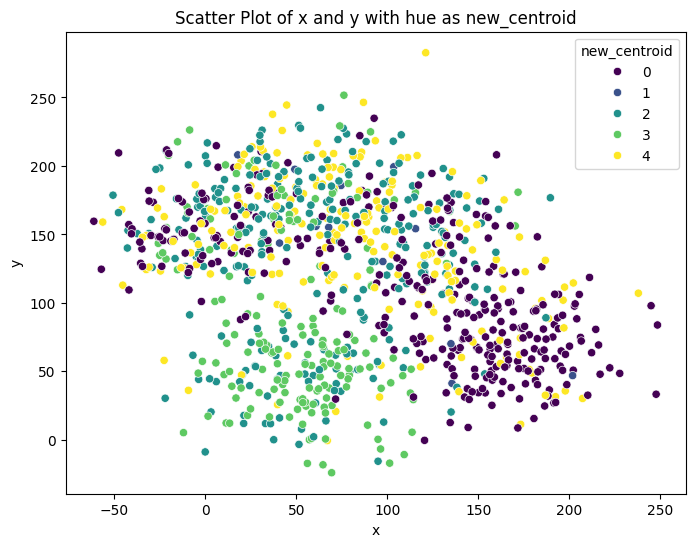

In [33]:
data = pd.DataFrame({'x': x, 'y': y, 'new_centroid': best_new_centroid})

plt.figure(figsize=(8, 6))
sns.scatterplot(data=data, x='x', y='y', hue='new_centroid', palette='viridis')
plt.title("Scatter Plot of x and y with hue as new_centroid")
plt.show()